In [1]:
import io
from itertools import product
import logging
L = logging.getLogger(__name__)
from pathlib import Path
import pickle
import yaml

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
import torch
from tqdm.auto import tqdm

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append("..")
from berp.datasets import BerpDataset, NestedBerpDataset
from berp.datasets.base import assert_compatible
from berp.datasets.eeg import load_eeg_dataset
from berp.datasets.splitters import KFold, train_test_split
import berp.trainer  # sets some nice yaml dump defaults
from berp.viz.trf import plot_trf_coefficients

In [4]:
workflow = "heilbron2022"
model = "distilgpt2"

# base_model_run_name = "trf.20221219"
# trf_run_name = "trf-berp-fixed.20221215"
# trf_run_name = "trf-berp-cannon.20221215.3quant"
# base_model_run_name = "trf"
# trf_run_name = "trf-berp-fixed"
base_model_run_name = "trf"
trf_run_name = "trf-berp-fixed.20230124"

# TODO this can/should be reloaded via Hydra flow rather than manually re-specified + loaded with copy-pasted logic below
subjects = list(range(1, 20)) # [14, 15, 16, 17, 18, 19]
runs = list(range(1, 20))
stories = ["old-man-and-the-sea"]

target_sensors = ["B19", "B20", "B22"]

# Match dataset spec.
normalize_X_ts = False
normalize_X_variable = True
normalize_Y = False

n_evaluation_folds = 4

In [5]:
all_run_names = [base_model_run_name, trf_run_name]
all_models = [model] * len(all_run_names) if isinstance(model, str) else model
assert len(all_models) == len(all_run_names)

model_dirs = [f"../workflow/{workflow}/results/{model}/{run_name}"
              for run_name, model in zip(all_run_names, all_models)]
dataset_dirs = [f"../workflow/{workflow}/data/dataset/{model}"
                for model in all_models]
stimulus_dirs = [f"../workflow/{workflow}/data/stimulus/{model}"
                 for model in all_models]

## Prepare dataset

In [6]:
# Load datasets.
ds = {}
ds_test = {}

for model, dataset_dir, stimulus_dir in zip(tqdm(all_models, unit="model"), dataset_dirs, stimulus_dirs):
    ds[model] = {}
    
    stimulus_paths = {f"{story}/run{run}": Path(stimulus_dir) / f"{story}/run{run}.pkl"
                      for story in stories for run in runs}
    combs = list(product(stories, subjects, runs))
    ds_paths = []
    for story, subject, run in tqdm(combs):
        ds_path = Path(dataset_dir) / story / f"sub{subject}" / f"run{run}.pkl"
        if not ds_path.exists():
            print(f"Could not find dataset {ds_path}")
            continue
        ds_paths.append(ds_path)

    nested_ds = load_eeg_dataset(
        ds_paths,
        subset_sensors=target_sensors,
        stimulus_paths=stimulus_paths,
        normalize_X_ts=normalize_X_ts, 
        normalize_X_variable=normalize_X_variable, 
        normalize_Y=normalize_Y)

    assert len(combs) == len(nested_ds.datasets)
    ds[model] = dict(zip(combs, nested_ds.datasets))
    
    # Create nested dataset.
    ds[model] = NestedBerpDataset(list(ds[model].values()), n_splits=8)
    # TODO hack, just replicating what is in trainer.
    ds_train, ds_test[model] = train_test_split(ds[model], test_size=.25)

  0%|          | 0/2 [00:00<?, ?model/s]

  0%|          | 0/361 [00:00<?, ?it/s]

  0%|          | 0/361 [00:00<?, ?it/s]

## Load, prime, and run pipelines

Run one-by-one because priming the whole dataset takes an enormous amount of memory.

In [7]:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)

In [8]:
def evaluate_pipeline(run_name, model_run_dir, ds_full, ds_test):
    pipeline_path = Path(model_run_dir) / "params" / "pipeline.pkl"
    if not pipeline_path.exists():
        raise ValueError(f"Missing pipeline at {pipeline_path}")
    
    with pipeline_path.open("rb") as f:
        pipe = CPU_Unpickler(f).load()
        
    print(f"=============== {run_name} @ {model_run_dir}")
    yaml.safe_dump(pipe.get_params(), sys.stdout)
    print()
    
    pipe.prime(ds_full)
    
    return pipe.score_multidimensional(ds_test).reshape((len(subjects), len(runs), len(target_sensors)))

In [9]:
test_scores = np.zeros((len(all_run_names), len(subjects), len(runs), len(target_sensors))) * np.nan

# NB `model_name` here corresponds to a language model; `model_run` corresponds to a run of the Berp model
for j, (run_name, model_run_dir, model_name) in enumerate(zip(tqdm(all_run_names, unit="pipe"), model_dirs, all_models)):
    test_scores[j] = evaluate_pipeline(run_name, model_run_dir, ds[model_name], ds_test[model_name])

  0%|          | 0/2 [00:00<?, ?pipe/s]

=============== trf @ ../workflow/heilbron2022/results/distilgpt2/trf
device: cuda
encoder: "TemporalReceptiveField(alpha=13687.841855161956, fit_intercept=True,\n \
  \                      n_outputs=3, name='9ed09996d7504034b0bfd1f86e91ba6c',\n \
  \                      optim=AdamSolver(n_batches=50,\n                        \
  \                name='9ed09996d7504034b0bfd1f86e91ba6c',\n                    \
  \                    random_state=RandomState(MT19937) at 0x2AB01A12D340),\n   \
  \                    sfreq=128.0, tmax=0.5625, tmin=0.0)"
encoder__alpha: 13687.841855161956
encoder__fit_intercept: true
encoder__init_scale: 0.1
encoder__n_outputs: 3
encoder__name: 9ed09996d7504034b0bfd1f86e91ba6c
encoder__optim: "AdamSolver(n_batches=50, name='9ed09996d7504034b0bfd1f86e91ba6c',\n\
  \           random_state=RandomState(MT19937) at 0x2AB01A12D340)"
encoder__optim__batch_size: 512
encoder__optim__early_stopping: 5
encoder__optim__learning_rate: 0.01
encoder__optim__n_batches: 

## Estimate test score

In [10]:
test_scores_df = []
for i_model_run, i_subj, i_run, i_sensor in np.ndindex(*test_scores.shape):
    test_scores_df.append((
        all_run_names[i_model_run],
        all_models[i_model_run],
        subjects[i_subj],
        runs[i_run],
        target_sensors[i_sensor],
        test_scores[i_model_run, i_subj, i_run, i_sensor]))
    
test_scores_df = pd.DataFrame(test_scores_df, columns=["model_run", "model", "subject", "run", "sensor", "score"]) \
    .groupby(["model_run", "model", "subject", "run", "sensor"]).mean()
test_scores_df

score
model_run model      subject run sensor          
trf       distilgpt2 1       1   B19     0.082200
                                 B20     0.070566
                                 B22     0.071646
                             2   B19    -0.052046
                                 B20     0.045746
...                                           ...
          gpt2       19      18  B20     0.059577
                                 B22     0.044203
                             19  B19     0.027744
                                 B20     0.014633
                                 B22     0.017391

[2166 rows x 1 columns]

In [ ]:
test_scores_df.to_csv((f"evaluate {all_models[1]}--{all_run_names[1]} - {all_models[0]}--{all_run_names[0]}.csv").replace("/", "--"))

### Compare means

In [11]:
test_scores.max(axis=-1).mean(axis=-1).mean(axis=-1)

array([0.07591828, 0.07614193])

In [12]:
(test_scores[1] - test_scores[0]).max(axis=-1).mean()

0.0012968847449858275

### Paired subjects t-test

In [13]:
# Do a paired t-test mirroring Heilbron comparison
tdf = test_scores_df.groupby(["model_run", "model", "subject", "run"]).score.mean() \
    .groupby(["model_run", "model", "subject"]).mean()
st.ttest_1samp(tdf.loc[(all_run_names[1], all_models[1])] - tdf.loc[(all_run_names[0], all_models[0])], popmean=0)

Ttest_1sampResult(statistic=1.9733192798928914, pvalue=0.06401446648719568)

<AxesSubplot:xlabel='model_run', ylabel='score'>

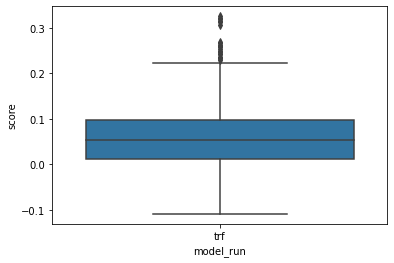

In [14]:
sns.boxplot(data=test_scores_df.reset_index(), x="model_run", y="score")

<AxesSubplot:xlabel='subject', ylabel='score'>

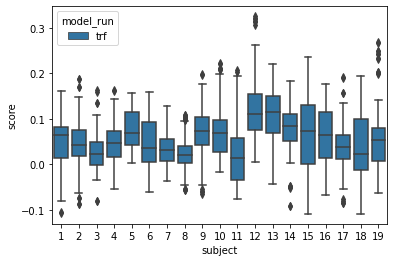

In [15]:
sns.boxplot(data=test_scores_df.reset_index(), x="subject", y="score", hue="model_run")

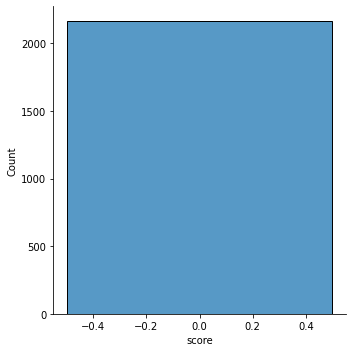

In [16]:
model_diffs = test_scores_df.loc[all_run_names[1]] - test_scores_df.loc[all_run_names[0]]
model_diffs = model_diffs.reset_index()
sns.displot(data=model_diffs, x="score")

Text(0, 0.5, 'Difference score')

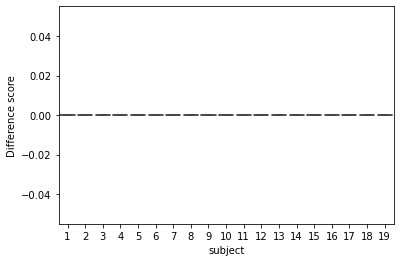

In [17]:
sns.boxplot(data=model_diffs, x="subject", y="score")
plt.ylabel("Difference score")

### Bootstrap estimate of difference within-subject

95% bootstrap CI: [0. 0.]


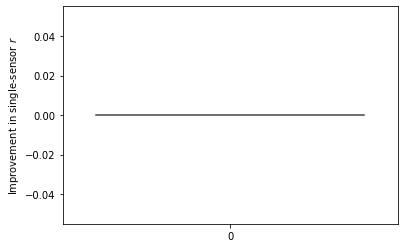

In [18]:
model_diffs_bootstrap = sns.algorithms.bootstrap(model_diffs.score, func="median", units=model_diffs.subject)
sns.violinplot(model_diffs_bootstrap)
plt.ylabel("Improvement in single-sensor $r$")
print("95% bootstrap CI:",
      np.quantile(model_diffs_bootstrap, (0.025, 0.975)))